In [111]:
#Committee & uncerstainity sampling
from modAL.models import ActiveLearner
from modAL.models import Committee

#the sampling strategies
from modAL.uncertainty import entropy_sampling, uncertainty_sampling, margin_sampling
from modAL.disagreement import vote_entropy_sampling, max_disagreement_sampling

#The algorithm for active learning
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd

# Problem 1(Using pool based sampling here)
## This section also has all experiments related to pool based pooling

## Method for uncertainity sampling

In [112]:
#this uses pool based pooling
def active_learning_single(X,y,n_queries,n_keep,query_strategy):
    idx_initial = np.random.choice(range(len(X)), size=n_keep, replace=False)
    idx_rem = [i for i in range(len(X)) if i not in idx_initial]

    x_initial = X[idx_initial]
    y_initial = y[idx_initial]

    x_rem = X[idx_rem]
    y_rem = y[idx_rem]
    
    act_learner = ActiveLearner(estimator=KNeighborsClassifier(n_neighbors=3),X_training=x_initial,y_training=y_initial,query_strategy=query_strategy)
    performance_track = []
    performance_track.append(act_learner.score(x_tes,y_tes))
    
    for i in range(n_queries):
        #picking out next 10% of data
        idx_next_10 = np.random.choice(range(x_rem.shape[0]),size=int(x.shape[0]*.1),replace=False)
        x_rem_10 = x_rem[idx_next_10]
        y_rem_10 = y_rem[idx_next_10]
        
        for j in range(x_rem_10.shape[0]):
            query_idx, query_instance = act_learner.query(x_rem_10)
            act_learner.teach(x_rem_10[query_idx], y_rem_10[query_idx])
            
            #removing the specific point
            x_rem_10 = np.delete(x_rem_10, query_idx, 0)
            y_rem_10 = np.delete(y_rem_10, query_idx, 0)
        
        #removing the 10% data
        x_rem = np.delete(x_rem, idx_next_10, 0) 
        y_rem = np.delete(y_rem, idx_next_10, 0)
        performance_track.append(act_learner.score(x_tes,y_tes))
        
    return performance_track

## Dataset Loading & Preprocessing

In [114]:
data_train = pd.read_csv('Data/pendigits.tra').to_numpy()
data_test = pd.read_csv('Data/pendigits.tes').to_numpy()

#data_for_training
x = data_train[:,:16]
y = data_train[:,16]

#data_for_testing
x_tes = data_test[:,:16]
y_tes = data_test[:,16]

## Method for QBC

In [116]:
def active_learning_committee(X,y,n_queries,n_committee,n_keep,query_strategy):    
    idx_initial = np.random.choice(range(len(X)), size=n_keep, replace=False)
    idx_rem = [i for i in range(len(X)) if i not in idx_initial]
    
    x_initial = X[idx_initial]
    y_initial = y[idx_initial]

    x_rem = X[idx_rem]
    y_rem = y[idx_rem]
    
    learners = []
    for i in range(n_committee):
        learner = ActiveLearner(estimator=KNeighborsClassifier(n_neighbors=3),X_training=x_initial,y_training=y_initial)
        learners.append(learner)
    
    committee = Committee(learner_list=learners,query_strategy=query_strategy)
    comm_perform = []
    comm_perform.append(committee.score(x_tes,y_tes))
    
    for i in range(n_queries):
        idx_next_10 = np.random.choice(range(x_rem.shape[0]),size=int(x.shape[0]*0.1),replace=False)
        x_rem_10 = x_rem[idx_next_10]
        y_rem_10 = y_rem[idx_next_10]
        
        for j in range(x_rem_10.shape[0]):
            query_idx,q_inst = committee.query(x_rem_10)
            #print(query_idx)
            committee.teach(x_rem_10[query_idx],y_rem_10[query_idx])
            #removing the specific point
            x_rem_10 = np.delete(x_rem_10,query_idx,0)
            y_rem_10 = np.delete(y_rem_10,query_idx,0)
        
        #removing the 10% data
        x_rem = np.delete(x_rem, idx_next_10, 0)
        y_rem = np.delete(y_rem, idx_next_10, 0) 
        comm_perform.append(committee.score(x_tes,y_tes))
        
    return comm_perform

# Evaluation

In [109]:
#Results on test data when we train on the whole dataset
out = KNeighborsClassifier(n_neighbors=3).fit(x,y)
print(out.score(x_tes,y_tes))

0.9779811266800115


In [88]:
#uncertainity evaluation, n_queries is 4 as with every query the number of points increase by 10%
least_confident_track = active_learning_single(x,y,4,int(x.shape[0]*0.1),uncertainty_sampling)
margin_sampling_track = active_learning_single(x,y,4,int(x.shape[0]*0.1),margin_sampling)
entropy_track = active_learning_single(x,y,4,int(x.shape[0]*0.1),entropy_sampling)

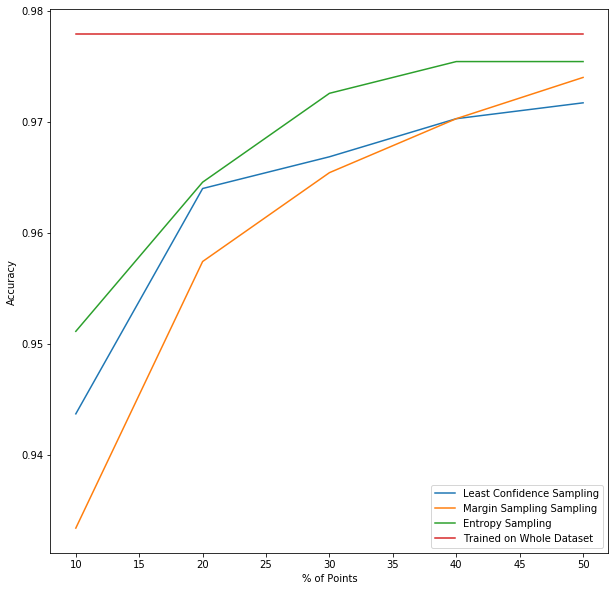

In [91]:
#plot for uncetainity sampling
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
x_axis = np.linspace(10.0,50.0,5)
plt.plot(x_axis,least_confident_track,label='Least Confidence Sampling')
plt.plot(x_axis,margin_sampling_track,label='Margin Sampling Sampling')
plt.plot(x_axis,entropy_track,label='Entropy Sampling')
plt.plot(x_axis,[0.9779 for i in range(5)],label ='Trained on Whole Dataset')
plt.xlabel('% of Points')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

In [117]:
#QBC evaluation, n_queries is 4 as with every query the number of points increase by 10%
kl_track = active_learning_committee(x,y,4,5,int(x.shape[0]*0.1),max_disagreement_sampling)
vote_track = active_learning_committee(x,y,4,5,int(x.shape[0]*0.1),vote_entropy_sampling)

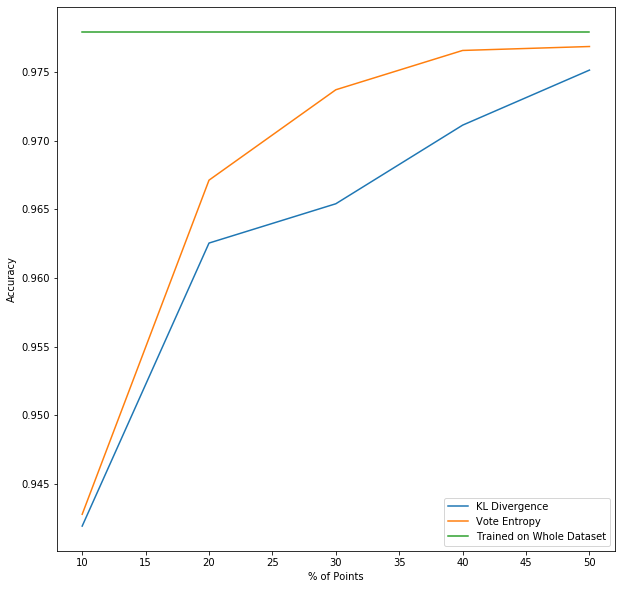

In [119]:
plt.figure(figsize=(10,10))
x_axis = np.linspace(10.0,50.0,5)
plt.plot(x_axis,kl_track,label='KL Divergence')
plt.plot(x_axis,vote_track,label='Vote Entropy')
plt.plot(x_axis,[0.9779 for i in range(5)],label ='Trained on Whole Dataset')
plt.xlabel('% of Points')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

In [122]:
print(least_confident_track,margin_sampling_track,entropy_track)

[0.9436659994280812, 0.9639691163854732, 0.9668287103231341, 0.9702602230483272, 0.9716900200171575] [0.9333714612525021, 0.9573920503288533, 0.9653989133543037, 0.9702602230483272, 0.9739776951672863] [0.9511009436659994, 0.9645410351730054, 0.9725478981984558, 0.9754074921361167, 0.9754074921361167]


In [123]:
print(kl_track,vote_track)

[0.9419502430654847, 0.9625393194166428, 0.9653989133543037, 0.9711181012296254, 0.9751215327423506] [0.9428081212467829, 0.9671146697169002, 0.9736917357735202, 0.976551329711181, 0.976837289104947]
